![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data









#Setup

In [1]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os

import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/balanced_data.zip"

In [4]:
DR_data = os.listdir('/content/balanced_data')

In [5]:
len(DR_data)

2500

###Create the images dataset

In [6]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(224,224)) # resize images
    x.append(np.array(img_imr))
  return x

In [7]:
data = create_img_set(os.path.join('/content/balanced_data'))

Show some images

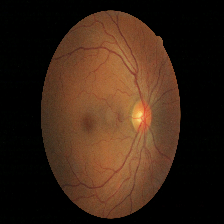

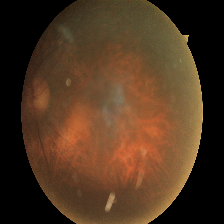

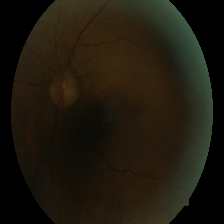

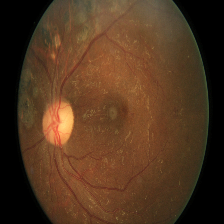

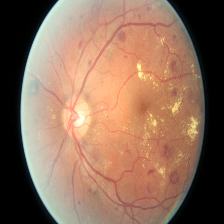

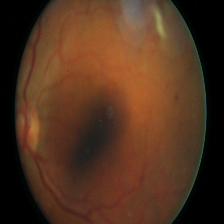

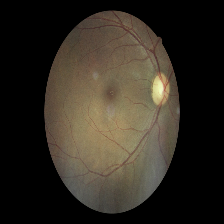

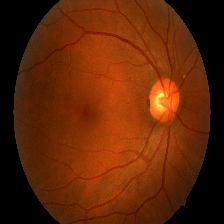

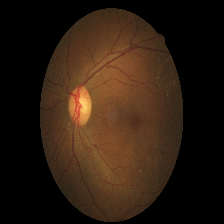

In [8]:
for i in range(0,9):
  cv2_imshow(data[i])

###Flattening and scale images

In [9]:
new_data = np.array(data)

In [10]:
new_data.shape

(2500, 224, 224, 3)

In [11]:
new_data = new_data/255.0

###Create label y

In [12]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [13]:
all_label

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


Let's check if the classes are balanced

In [14]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Let's extract labels

In [15]:
label = []

In [16]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [17]:
label = pd.DataFrame(label,columns=['image'])

In [18]:
label

,image
0,252_right
1,115_left
2,4674_left
3,29839_right
4,18656_right
...,...
2495,609_left
2496,12861_left
2497,14084_right
2498,1607_left


In [19]:
new_label = pd.merge(label, all_label, on=['image'])

In [20]:
new_label

,image,level
0,252_right,0
1,115_left,0
2,4674_left,3
3,29839_right,4
4,18656_right,3
...,...,...
2495,609_left,3
2496,12861_left,4
2497,14084_right,4
2498,1607_left,2


Check the balance of the classes

In [21]:
print(new_label.groupby('level').nunique())

       image
level       
0        500
1        500
2        500
3        500
4        500


Let's verify with first and last file name to see if it's matched.

In [22]:
DR_data[0], new_label['image'][0]

('252_right.jpeg', '252_right')

In [23]:
DR_data[500], new_label['image'][500]

('19961_left.jpeg', '19961_left')

In [24]:
DR_data[1000], new_label['image'][1000]

('15798_right.jpeg', '15798_right')

Therefore, the new label is created correctly and good to go!!!

In [25]:
target = new_label['level']

Split training and testing set 80:20

In [26]:
X_train, X_test, y_train, y_test = train_test_split(new_data, target, test_size=0.2, random_state=42)

Convert y to categorical 

In [27]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [28]:
y_train_cat = to_categorical(y_train, num_classes=len(class_name))

In [29]:
y_test_cat = to_categorical(y_test, num_classes=len(class_name))

###Data Augmentation

In [30]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=16, width_shift_range=0.2, shear_range=0.2, height_shift_range=0.2, zoom_range=0.2, 
                         featurewise_center=True, horizontal_flip=True, featurewise_std_normalization=True)
data_aug = gen.flow(X_train, y_train_cat, batch_size=20)

##Transfer Learning - Keras Model InceptionV3

In [31]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import regularizers, optimizers

In [32]:
#Instatiate some optimizers 
sgd = optimizers.SGD(learning_rate=0.001)
rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [137]:
model = load_model('google_model.h5')

In [138]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 1280)              410208    
_________________________________________________________________
sequential_11 (Sequential)   (None, 5)                 128600    
Total params: 538,808
Trainable params: 524,728
Non-trainable params: 14,080
_________________________________________________________________


In [139]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='sgd',
  metrics=['accuracy']
)

##Retrain the model

In [140]:
tr = model.fit(X_train,
                   y_train_cat,
                   batch_size=20, 
                   epochs=100,
                   validation_data=data_aug)

Epoch 1/100
100/100 [==============================] - 25s 251ms/step - loss: 1.9388 - accuracy: 0.3200 - val_loss: 3.7579 - val_accuracy: 0.1965
Epoch 2/100
100/100 [==============================] - 24s 241ms/step - loss: 1.2428 - accuracy: 0.4835 - val_loss: 2.8474 - val_accuracy: 0.1965
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 1.0661 - accuracy: 0.5630 - val_loss: 3.1812 - val_accuracy: 0.1965
Epoch 4/100
100/100 [==============================] - 24s 238ms/step - loss: 0.9002 - accuracy: 0.6565 - val_loss: 2.6512 - val_accuracy: 0.1975
Epoch 5/100
100/100 [==============================] - 24s 240ms/step - loss: 0.7595 - accuracy: 0.7065 - val_loss: 2.3298 - val_accuracy: 0.2030
Epoch 6/100
100/100 [==============================] - 24s 239ms/step - loss: 0.6184 - accuracy: 0.7770 - val_loss: 2.2611 - val_accuracy: 0.2215
Epoch 7/100
100/100 [==============================] - 24s 239ms/step - loss: 0.5083 - accuracy: 0.8075 - val_loss: 2.1831 -

###Plot the learning curve

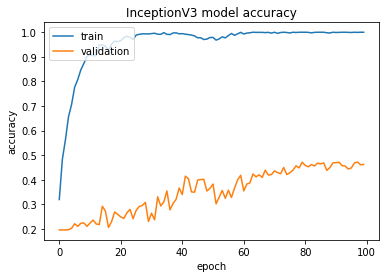

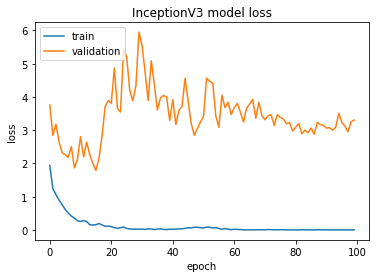

In [141]:
plt.plot(tr.history['accuracy'])
plt.plot(tr.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr.history['loss'])
plt.plot(tr.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##See the accuracy

In [142]:
train_score = model.evaluate(X_train, y_train_cat, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

Train loss: 0.0029355394653975964
Train accuracy: 0.9994999766349792


In [143]:
test_score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 3.684786796569824
Test accuracy: 0.4000000059604645


###See the prediction

In [144]:
pred_test = model.predict(X_test, verbose=0)

In [145]:
pred_test = np.argmax(pred_test,axis=1)

In [146]:
pred_test

array([2, 3, 0, 3, 4, 0, 3, 3, 0, 3, 4, 4, 4, 4, 2, 4, 4, 3, 4, 0, 1, 1,
       1, 1, 3, 4, 4, 4, 2, 1, 4, 1, 3, 1, 4, 3, 4, 0, 0, 0, 1, 0, 2, 3,
       0, 0, 4, 2, 3, 2, 1, 0, 0, 0, 1, 1, 0, 0, 4, 4, 4, 2, 1, 0, 3, 4,
       3, 3, 0, 1, 2, 1, 4, 1, 0, 1, 4, 4, 0, 4, 1, 0, 0, 4, 4, 4, 2, 2,
       0, 1, 0, 0, 1, 0, 0, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 4, 4, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 3, 0, 1, 2, 1, 1, 0, 3, 4, 2, 1, 1, 4, 4, 4, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 2, 4, 3, 0, 3, 4, 4, 1, 2,
       3, 1, 1, 1, 0, 3, 0, 4, 2, 4, 0, 1, 1, 4, 1, 1, 0, 4, 3, 1, 1, 0,
       0, 1, 4, 4, 2, 0, 4, 2, 0, 0, 2, 1, 3, 0, 1, 0, 3, 2, 0, 1, 4, 0,
       0, 3, 1, 4, 4, 0, 4, 3, 3, 1, 0, 1, 0, 1, 1, 0, 0, 4, 0, 1, 4, 3,
       1, 0, 2, 4, 1, 0, 2, 4, 2, 3, 2, 4, 4, 4, 1, 1, 0, 0, 3, 2, 4, 0,
       3, 3, 2, 0, 3, 3, 0, 4, 1, 3, 3, 0, 0, 1, 1, 1, 4, 4, 0, 4, 1, 3,
       3, 3, 1, 2, 0, 0, 1, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 3, 1, 0,
       0, 0, 3, 4, 1, 4, 1, 0, 0, 4, 2, 4, 4, 3, 4,

###Classification Report

In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.33      0.44      0.37       103
            Mild       0.31      0.35      0.33       109
        Moderate       0.29      0.16      0.20        95
          Severe       0.46      0.36      0.41        86
Proliferative DR       0.60      0.66      0.63       107

        accuracy                           0.40       500
       macro avg       0.40      0.39      0.39       500
    weighted avg       0.40      0.40      0.39       500



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

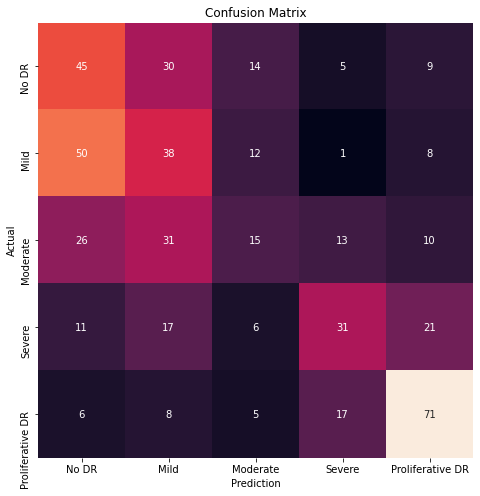

In [148]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

##Reduce Overfitting

In [149]:
callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

In [150]:
tr1 = model.fit(X_train,
                   y_train_cat,
                   batch_size=20,
                   epochs=100,
                   validation_data=data_aug,
                   callbacks=[callback])

Epoch 1/100
100/100 [==============================] - 24s 245ms/step - loss: 6.0718e-04 - accuracy: 1.0000 - val_loss: 3.2058 - val_accuracy: 0.4595
Epoch 2/100
100/100 [==============================] - 24s 241ms/step - loss: 7.0516e-04 - accuracy: 1.0000 - val_loss: 3.1284 - val_accuracy: 0.4780
Epoch 3/100
100/100 [==============================] - 24s 241ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.2972 - val_accuracy: 0.4695
Epoch 4/100
100/100 [==============================] - 24s 241ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 3.5790 - val_accuracy: 0.4410
Epoch 5/100
100/100 [==============================] - 24s 240ms/step - loss: 3.6117e-04 - accuracy: 1.0000 - val_loss: 3.5070 - val_accuracy: 0.4455
Epoch 6/100
100/100 [==============================] - 24s 242ms/step - loss: 8.1932e-04 - accuracy: 1.0000 - val_loss: 3.3082 - val_accuracy: 0.4595
Epoch 7/100
100/100 [==============================] - 24s 242ms/step - loss: 0.0043 - accuracy: 0.9985 - va

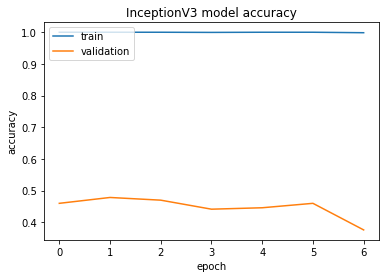

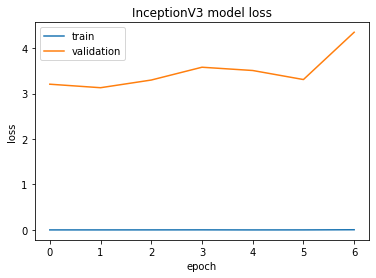

In [151]:
plt.plot(tr1.history['accuracy'])
plt.plot(tr1.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr1.history['loss'])
plt.plot(tr1.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Check the new accuracy

In [152]:
train_score = model.evaluate(X_train, y_train_cat, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])

Train loss: 0.0014913063496351242
Train accuracy: 1.0


In [153]:
test_score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 3.6061275005340576
Test accuracy: 0.41600000858306885


###See the prediction

In [154]:
pred_test = model.predict(X_test, verbose=0)

In [155]:
pred_test = np.argmax(pred_test,axis=1)

###Classification Report

In [156]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test, target_names=class_name))

                  precision    recall  f1-score   support

           No DR       0.34      0.43      0.38       103
            Mild       0.33      0.36      0.34       109
        Moderate       0.31      0.20      0.24        95
          Severe       0.50      0.37      0.43        86
Proliferative DR       0.59      0.69      0.64       107

        accuracy                           0.42       500
       macro avg       0.41      0.41      0.41       500
    weighted avg       0.41      0.42      0.41       500



###Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

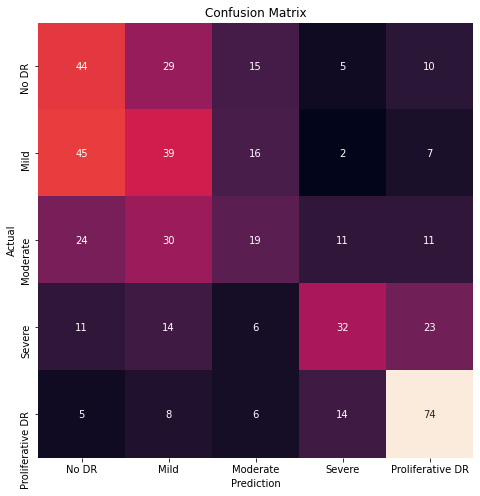

In [157]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

In [158]:
#Save the model
from tensorflow.keras.models import load_model
model.save('Google-Model.h5')